#**MSR** 

The aim of this code is to compute the MSR score associated to some (or all) of the neurons of which spiking activity has been recorded (Stensola et al., 2012).

In [ ]:
pip install mat4py

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import mat4py

from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats.stats import pearsonr

from tqdm import tqdm

Loading the dataset from the Cubero et. al GitHub repository.

In [ ]:
!git clone https://github.com/rcubero/MSR.git

Cloning into 'MSR'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 6.06 MiB | 30.39 MiB/s, done.
Resolving deltas: 100% (23/23), done.


Conversion of the cell_names file into a string array from which to extract the dataset name.

In [ ]:
cell_names = open("MSR/Flekken_Data/cell_filenames", "r")
cell_names = cell_names.read().splitlines()

Initialization of the files where to save the lists containing the MSR, SI, and HDI scores, later to be used for comparison with the correspondent results obtained by Cubero.

In [ ]:
MSR_txt = open('MSR_Betteti.txt', 'w')
SI_txt = open('SI_Betteti.txt', 'w')
HD_txt = open('HD_Betteti.txt', 'w')

##Functions

Definition of the main functions that will be used in main to compute the relevant measures.

Extraction of data from the BEN folder.

In [ ]:
def extract_data(name):
  # Extract data from the folder MSR/Flekken_Data/BEN/...
  name_n = "MSR/Flekken_Data/"+name
  data_raw = mat4py.loadmat(name_n)
  data = np.array(data_raw["cellTS"]).squeeze()

  return data

Function creating a numpy array containing the number of spikes for each time bin in the data, later to be used for the computation of the resolution and relevance measures.

In [ ]:
def counter_s(data, t, mx):
  # Creates a time partition for the given data according to the number of intervals t
  time_mesh = np.linspace(0, mx, t)

  # Counter for the number of spikes
  spk_ctr = []
  for i in range(len(time_mesh)):
    data_c=np.copy(data)
    data_c[data_c<=time_mesh[i-1]]=0
    data_c[data_c>time_mesh[i]]=0
    inst = np.count_nonzero(data_c)
    spk_ctr.append(inst)

  return np.array(spk_ctr, dtype=np.int64)

Counter for the number of time bins associated to an equal number of spikes.

In [ ]:
def counter_k(spk_ctr):
  inst_ctr = []
  # While cycle that counts the number of bins within which the same number of spikes occurs
  while len(np.nonzero(spk_ctr!=-1)[0])>0:
    idx = np.nonzero(spk_ctr!=-1)[0][0]
    # Number of spikes
    val = spk_ctr[idx]
    # Number of time bins having number of spikes "val"
    n_val = len(np.nonzero(spk_ctr==val)[0])
    
    inst_ctr.append(np.array([val, n_val], dtype=np.int64))

    spk_ctr[spk_ctr==val]=-1
  
  return inst_ctr

Definition of the resolution measure.

In [ ]:
def hs(spk_ctr, spk_tot):
  # information extracted at different resolutions
  h_s=0
  for spk in spk_ctr:
    if spk!=0:
      h_s -= (1/np.log(spk_tot))*(spk/spk_tot)*np.log(spk/spk_tot)
    else:
      h_s = h_s

  return h_s


Definition of the relevance measure.

In [ ]:
def hk(inst_ctr, spk_tot):
  # relevance of the information extracted for different resolutions
  h_k = 0
  for inst in inst_ctr:
    if inst[0]!=0:
      h_k -=(1/np.log(spk_tot))*(inst[0]*inst[1]/spk_tot)*np.log(inst[0]*inst[1]/spk_tot)
    else:
      h_k = h_k

  return h_k

Definition of a function returning the MSR score of the 10 most relevant neurons, according to the measure, and the respective H[S]-H[K] graphs.

In [ ]:
def ranking(MSRs, Main_Ne, cell_names):
  # Creation of a copy of MSRs for ordering and indexing
  temp = np.argsort(MSRs)
  for j in range(10):
    name = cell_names[temp[-j-1]]
    txt = 'MSR neuron_'+str(Main_Ne[name]['Neuron'])
    # Data info
    print('###################################')
    print('Neuron: '+str(Main_Ne[name]['Neuron']))
    print('MSR: '+str(Main_Ne[name]['MSR'][0]))
    # Visual info
    f = interp1d(Main_Ne[name]['H[S]'], Main_Ne[name]['H[K]'], kind='linear')
    ax = np.linspace(0, 1, 1000)
    fg = 'Neuron: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))

    plt.figure(figsize=(10,8))
    plt.plot(Main_Ne[name]['H[S]'], Main_Ne[name]['H[K]'], "o", ax, f(ax), "-", label="H[S]-H[K] graph")
    plt.fill_between(Main_Ne[name]['H[S]'], Main_Ne[name]['H[K]'], color="thistle")
    plt.xlabel('H[S]')
    plt.ylabel('H[K]')
    plt.savefig(txt)
    plt.show()
    plt.close()

##Main

Main body of the program, containing the cycles computing H[S], H[K], and MSR for every neuron in the dataset.


1.   MSR: scalar
2.   H[S]: array(150, 1)
3.   H[K]: array(150, 1)



In [ ]:
time_steps_1 = np.linspace(1, 80, 40, dtype=np.int64)
time_steps_2 = np.linspace(100, 20000, 110, dtype=np.int64)
time_steps = np.concatenate((time_steps_1, time_steps_2))
Main_Ne = {}

In [ ]:
# Number of the neuron (counter)
n_neu = 1
MSRs = []
mx = 12593

for name in cell_names:
  # Definition of structures for the scoring of the relevant measures
  Neu = {}
  H_S = []
  H_K = []

  # Definition of the data
  data = extract_data(name)
  #mx = np.max(data)

  # Total number of spikes in the current time series
  spk_tot = len(data)

  for t in tqdm(time_steps):

    # Definition of the counters (spikes, bins)
    spk_ctr = counter_s(data, t, mx)
    spk_hold = np.copy(spk_ctr)
    inst_ctr = counter_k(spk_hold)

    # Resolution and Relevance measure
    h_s = hs(spk_ctr, spk_tot)
    h_k = hk(inst_ctr, spk_tot)

    H_S.append(h_s)
    H_K.append(h_k)
  
  H_S.append(1)
  H_K.append(0)

  f = interp1d(H_S, H_K, kind='linear')
  MSR = quad(f, 0, 1)

  MSR_txt.write(str(MSR[0])+'\n')
  MSRs.append(MSR[0])

  Neu["Neuron"] = n_neu
  Neu["H[S]"] = H_S
  Neu["H[K]"] = H_K
  Neu["MSR"] = MSR

  Main_Ne[name]=Neu

  n_neu += 1

100%|██████████| 150/150 [00:42<00:00,  3.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
100%|██████████| 150/150 [00:18<00:00,  8.21it/s]


Plotting of a sample of H[S]-H[K] graphs from the entire dataset and the respective MSR score (Top ten neurons according to MSR measure)

###################################
Neuron: 47
MSR: 0.2985933236266411


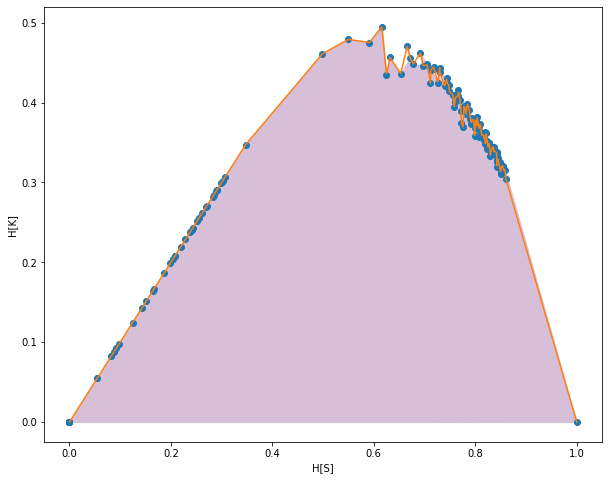

###################################
Neuron: 48
MSR: 0.2975758413293613


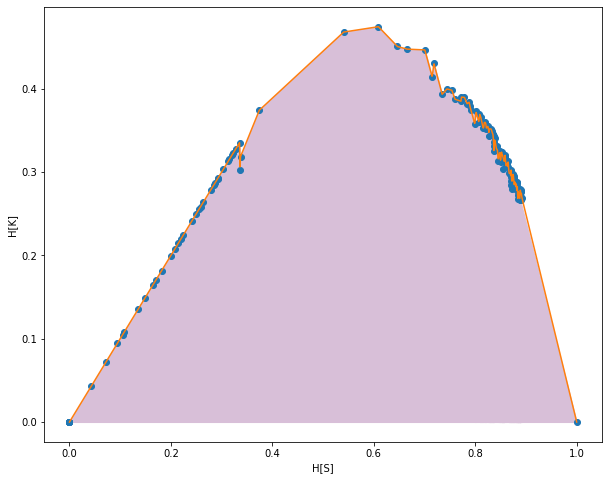

###################################
Neuron: 35
MSR: 0.2971573575205887


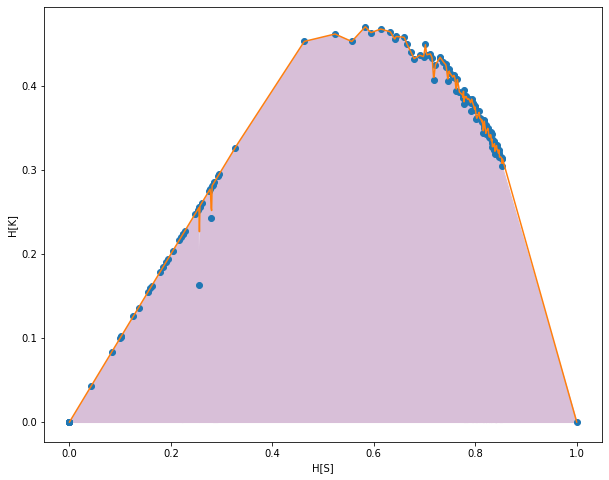

###################################
Neuron: 45
MSR: 0.2929240914312697


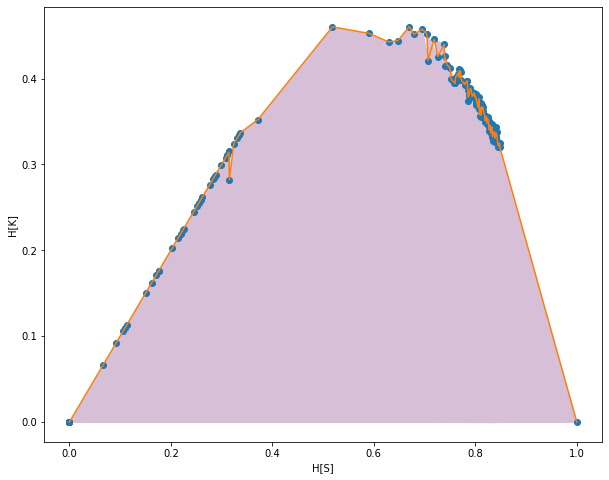

###################################
Neuron: 63
MSR: 0.2906454902607293


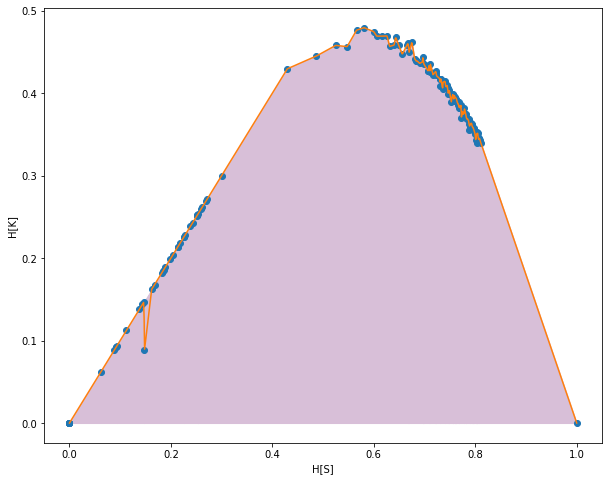

###################################
Neuron: 6
MSR: 0.29005698524867046


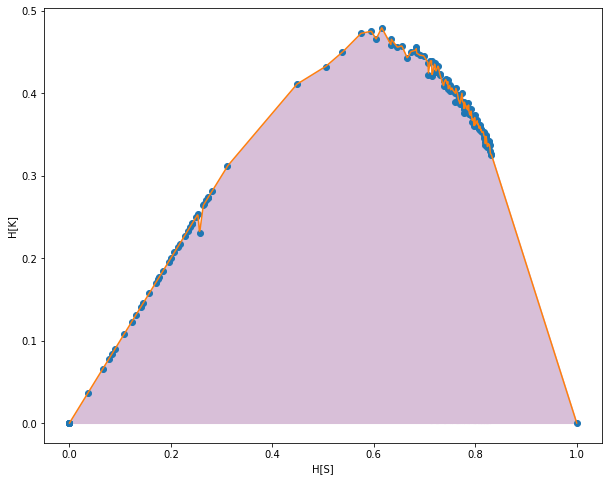

###################################
Neuron: 3
MSR: 0.28991906598308353


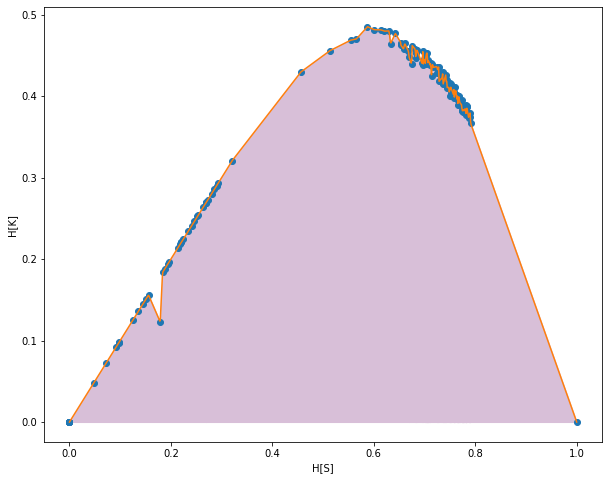

###################################
Neuron: 62
MSR: 0.28963710746482985


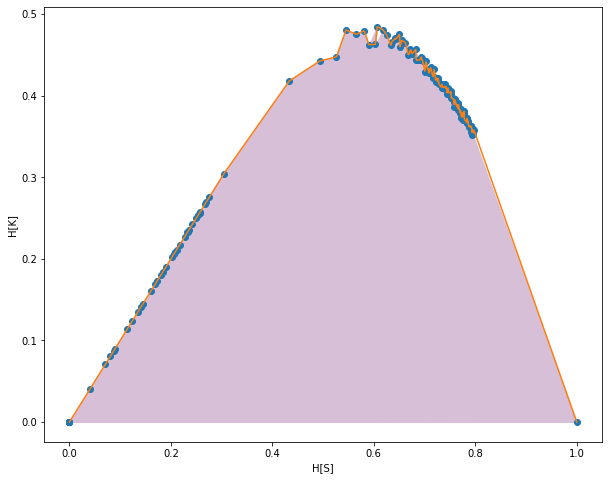

###################################
Neuron: 64
MSR: 0.28962438374642


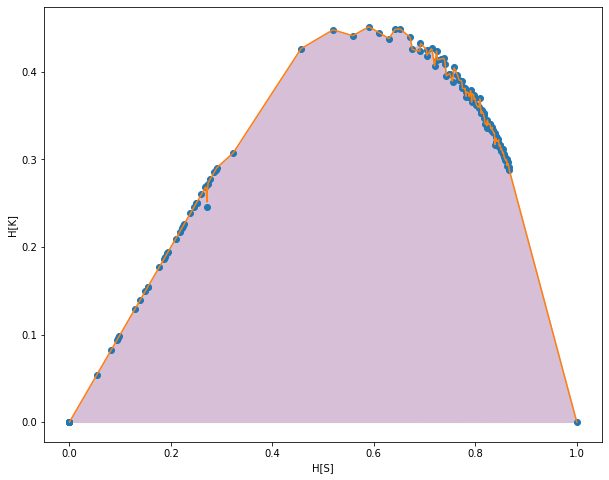

###################################
Neuron: 31
MSR: 0.28909910927184257


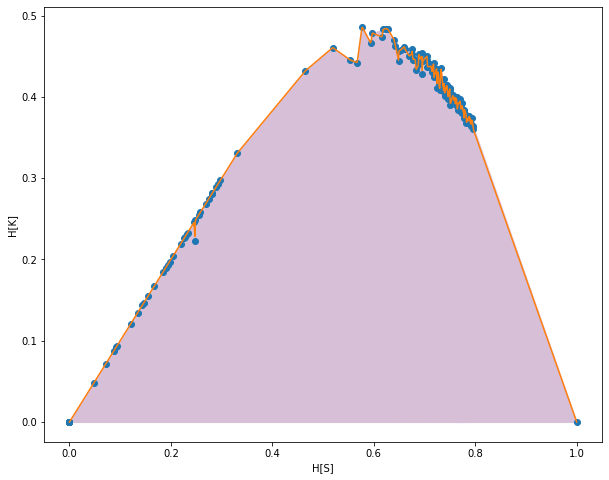

In [ ]:
ranking(MSRs, Main_Ne, cell_names)

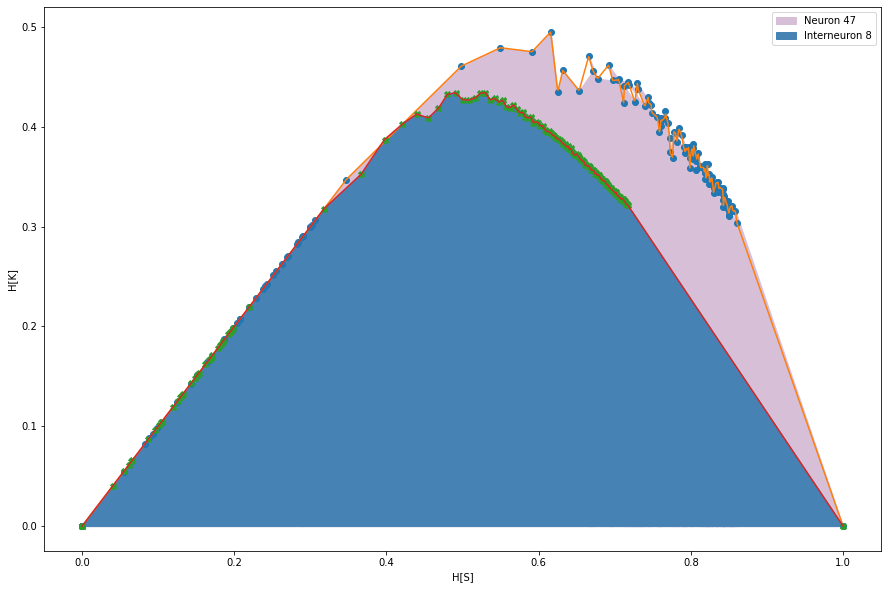

In [ ]:
# MSR comparison between Neuron 47 and Interneuron 8

f_47 = interp1d(Main_Ne['BEN/BEN_T08C5.mat']['H[S]'], Main_Ne['BEN/BEN_T08C5.mat']['H[K]'], kind='linear')
f_8 = interp1d(Main_Ne['BEN/BEN_T02C2.mat']['H[S]'], Main_Ne['BEN/BEN_T02C2.mat']['H[K]'], kind='linear')
ax = np.linspace(0, 1, 1000)

plt.figure(figsize=(15,10))
plt.plot(Main_Ne['BEN/BEN_T08C5.mat']['H[S]'], Main_Ne['BEN/BEN_T08C5.mat']['H[K]'], "o", ax, f_47(ax), "-")
plt.fill_between(Main_Ne['BEN/BEN_T08C5.mat']['H[S]'], Main_Ne['BEN/BEN_T08C5.mat']['H[K]'], color="thistle", label ="Neuron 47")
plt.plot(Main_Ne['BEN/BEN_T02C2.mat']['H[S]'], Main_Ne['BEN/BEN_T02C2.mat']['H[K]'], "X", ax, f_8(ax), "-")
plt.fill_between(Main_Ne['BEN/BEN_T02C2.mat']['H[S]'], Main_Ne['BEN/BEN_T02C2.mat']['H[K]'], color="steelblue", label ="Interneuron 8")
plt.xlabel('H[S]')
plt.ylabel('H[K]')
plt.legend()
plt.savefig('MSR Comparison')
plt.show()
plt.close()

## Spatial Information (Skaggs 1997)

In [ ]:
data_pos = mat4py.loadmat('MSR/Flekken_Data/BEN/BEN_pos.mat')

# Raw positional values (not appropriately scaled)

# First try
pos_x = np.array(data_pos['posx'])
pos_y = np.array(data_pos['posy'])
# Second try
pos_x2 = np.array(data_pos['posx2'])
pos_y2 = np.array(data_pos['posy2'])

post = np.array(data_pos['post'])

avg_posx = (pos_x + pos_x2)/2.0
avg_posy = (pos_y + pos_y2)/2.0

HD = np.arctan2((pos_y2-pos_y),(pos_x2-pos_x))+np.pi

Definition of a rescaling function useful to bring the given value in the space [0, 150]x[0, 150].

In [ ]:
def rescaling(posx, posy):

  # definition of minimal and maximal values for each coordinate
  m_x = np.min(posx)
  M_x = np.max(posx)

  m_y = np.min(posy)
  M_y = np.max(posy)

  pos_x = (posx-m_x)*150/(M_x-m_x)
  pos_y = (posy-m_y)*150/(M_y-m_y)

  return pos_x, pos_y

Definition of a new repmat function that repeats each element in a vector the specified amount of times.

In [ ]:
def repmat(x,v):
  x_v = []
  for i in range(len(x)):
    if v[i]!=0:
      add = x[i]*np.ones(v[i])
      x_v = np.concatenate((x_v, add))

  return np.array(x_v)

### Main and convolutions

In [ ]:
def center_m(l, t):
  # definition of a matrix containing center coordinates for each
  # of the bins in the box
  centers = np.zeros((50,50,2))

  for i in range(l):
    for j in range(l):
      centers[i, j, 0] = t/2 + i*t
      centers[i, j, 1] = t/2 + j*t 

  return centers

In [ ]:
def center_v(l, t):
  # definition of the vector containing center coordinates for each
  # of the bins in the angular interval

  centers = np.zeros(l)

  for i in range(40):
    centers[i] = (t/2+i*t)*(np.pi/360)

  return centers

Definition of the convolution operation for the kernel smoothed rate map and the probabilities necessary for the computation of the spatial information score (and HD score).

In [ ]:
def Kernel(i, j, centers, sigma, l):

  kernels = np.zeros((l,l))
  if sigma==0:
    sigma = 0.01

  coord_cent = centers[i, j, :]
  for k in range(l):
    for h in range(l):
        kernels[k, h] = (2*np.pi*((1/sigma)**(1/6)))**(-1/2)*np.exp(-np.linalg.norm(coord_cent-centers[k, h, :])**(2)/(2*((1/sigma)**(1/6))))
  
  return kernels

In [ ]:
def Kernel_hd(i, centers, sigma, l):

  kernels = np.zeros(l)
  if sigma == 0:
    sigma = 0.01

  coord_cent = centers[i]
  for j in range(l):
    kernels[j] = (2*np.pi*((1/sigma)**(1/100)))**(-1/2)*np.exp(-(coord_cent-centers[j])**(2)/(2*((1/sigma)**(1/100))))

  return kernels

Smoothing convolutions for both p(x) and lambda(x).

In [ ]:
def smoothing_sp(centers, spk_c, lambda_x, p_x, l, t):

  lambda_x_smooth = np.zeros((l,l))
  p_x_smooth = np.zeros((l,l))

  for i in tqdm(range(l)):
    for j in range(l):
      kernels = Kernel(i, j, centers, spk_c[i,j], l)
      p_x_smooth[i,j] = np.sum(np.multiply(p_x, kernels))
      lambda_x_smooth[i,j] = np.sum(np.multiply(lambda_x, kernels))

  return lambda_x_smooth, p_x_smooth

In [ ]:
def smoothing_hd(centers, spk_c, lambda_x, p_x, l, t):

  lambda_x_smooth = np.zeros(l)
  p_x_smooth = np.zeros(l)

  for i in tqdm(range(l)):
    kernels = Kernel_hd(i, centers, spk_c[i], l)
    p_x_smooth[i] = np.sum(np.multiply(p_x, kernels))
    lambda_x_smooth[i] = np.sum(np.multiply(lambda_x, kernels))

  return lambda_x_smooth, p_x_smooth

Definition of the ranking function according to their spatial information score (smoothed).

In [ ]:
def ranking_sp(SI_SM, Main_Ne, cell_names):
  # Sorting of the neurons according to the score on the 
  # spatial information measure
  temp = np.argsort(SI_SM)
  for j in range(10):
    name = cell_names[temp[-j-1]]
    txt_ns = 'SI neuron_'+str(Main_Ne[name]['Neuron'])
    txt_s = 'Smoothed SI neuron_'+str(Main_Ne[name]['Neuron'])
    print('--------------------------------------')
    print('Neuron: '+str(Main_Ne[name]['Neuron']))
    print('SI: '+str(Main_Ne[name]['SI']['SI']))
    print('Smooth SI: '+str(Main_Ne[name]['SI_smooth']['SI']))
    print('MSR: '+str(Main_Ne[name]['MSR']))
    lab_ns = 'Neuron: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))+'\n'+'SI: '+str(round(Main_Ne[name]['SI']['SI'],4))
    lab_s = 'Neuron: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))+'\n'+'SI: '+str(round(Main_Ne[name]['SI_smooth']['SI'],4))

    plt.figure(figsize=(12,8))
    plt.imshow(Main_Ne[name]['SI']['lambda(x)'], cmap='jet', interpolation='spline36')
    plt.colorbar()
    plt.figtext(0.92, 0.5, lab_ns)
    plt.savefig(txt_ns)
    plt.show()
    plt.close()

    plt.figure(figsize=(12,8))
    plt.imshow(Main_Ne[name]['SI_smooth']['lambda(x)'], cmap='jet', interpolation='spline36')
    plt.colorbar()
    plt.figtext(0.92, 0.5, lab_s)
    plt.savefig(txt_s)
    plt.show()
    plt.close()

Definition of the main for the simple and kernel smoothed spatial information measure.

In [ ]:
# Definition of the general data to be used
posx, posy = rescaling(avg_posx, avg_posy)

times = np.arange(np.min(post), np.max(post), step=0.01)
t = 7.5
bins = np.arange(0, 150+t, t)
l = len(bins)-1


In [ ]:
SI_SM = []
SI_NSM = []

# Definition of the parametric curves describing the mouse position and velocity in space
f_posx = CubicSpline(post, posx)
f_posx_p = f_posx(times)
df_posx_p = np.gradient(f_posx_p, times)

f_posy = CubicSpline(post, posy)
f_posy_p = f_posy(times)
df_posy_p = np.gradient(f_posy_p, times)

speed_coord = np.array((df_posx_p, df_posy_p))
speed = np.linalg.norm(speed_coord, axis=0)

# Matrix of centers for the bins
centers = center_m(l, t)

for name_n in cell_names:

  si = {}
  si_smooth = {}

  neu_tdata = extract_data(name_n)

  # Counter for the number of spikes of neuron neu in each time bin
  binned_spikes, _ = np.histogram(neu_tdata, times)

  # Setting to zero the spike count for those time bins where the mouse velocity
  # less than a specified threshold
  bin_spk = np.copy(binned_spikes)
  bin_spk[speed[0:-1]<5.0] = 0 

  spk_x = repmat(f_posx_p[1:-1], bin_spk)
  spk_y = repmat(f_posy_p[1:-1], bin_spk)

  spk_c, _, _ = np.histogram2d(spk_x, spk_y, [bins, bins])
  pos_c, _, _ = np.histogram2d(f_posx_p, f_posy_p, [bins, bins])

  ######################################
  # Simple spatial information measures
  p_x = pos_c/np.sum(pos_c)
  lambda_x = spk_c/np.max(times)

  lambda_hat = np.sum(np.multiply(lambda_x, p_x))
  w = lambda_x/lambda_hat
  # Correction term for when lambda_x=0
  lambda_adj = np.copy(lambda_x)
  lambda_adj[lambda_adj==0] = lambda_hat
  log_w = np.log(lambda_adj/lambda_hat)/np.log(2)

  SI = np.sum(np.multiply(np.multiply(w, log_w), p_x)) 

  si['SI'] = SI
  si['lambda(x)'] = lambda_x
  si['p(x)'] = p_x

  SI_NSM.append(SI)

  #######################################
  # Smoothed spatial information measures
  lambda_x_smooth, p_x_smooth = smoothing_sp(centers, spk_c, lambda_x, p_x, l, t)

  lambda_tilde = np.sum(np.multiply(lambda_x_smooth, p_x_smooth))
  w_smooth = lambda_x_smooth/lambda_tilde
  lambda_adj_sm = np.copy(lambda_x_smooth)
  lambda_adj_sm[lambda_adj_sm==0] = lambda_tilde
  log_w_smooth = np.log(lambda_adj_sm/lambda_tilde)/np.log(2)

  SI_smooth = np.sum(np.multiply(np.multiply(w_smooth, log_w_smooth),p_x_smooth))

  si_smooth['SI'] = SI_smooth
  si_smooth['lambda(x)'] = lambda_x_smooth
  si_smooth['p(x)'] = p_x_smooth

  SI_txt.write(str(SI_smooth)+'\n')
  SI_SM.append(SI_smooth)

  # Saving in the Main_Ne dictionary
  Main_Ne[name_n]['SI'] = si
  Main_Ne[name_n]['SI_smooth'] = si_smooth

100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


In [ ]:
HD_SM = []
HD_NSM = []

# Definition of the parametric curve describing the mouse HD
f_HD = CubicSpline(post, HD)
f_HD_p = f_HD(times)

t = 9
bins_HD = np.arange(0, 360+t, t)*(np.pi/360) 
l = len(bins_HD)-1

for name in cell_names:

  hd = {}
  hd_smooth = {}

  neu_tdata = extract_data(name)

  centers = center_v(l, t)

  # Counter for the number of spikes of neuron neu in each time bin
  binned_spikes, _ = np.histogram(neu_tdata, times)

  spk_HD = repmat(f_HD_p[1:-1], binned_spikes)

  spk_c, _ = np.histogram(spk_HD, bins_HD)
  HD_c , _ = np.histogram(f_HD_p, bins_HD)

  ######################################
  # Simple HD information measure
  p_x = HD_c/np.sum(HD_c)
  lambda_x = spk_c/np.max(times)

  lambda_hat = np.sum(np.multiply(lambda_x, p_x))
  w = lambda_x/lambda_hat
  # Correction term for when lambda_x=0
  lambda_adj = np.copy(lambda_x)
  lambda_adj[lambda_adj==0] = lambda_hat
  log_w = np.log(lambda_adj/lambda_hat)/np.log(2)

  HD_I = np.sum(np.multiply(np.multiply(w, log_w), p_x)) 

  hd['HD'] = HD_I
  hd['lambda(x)'] = lambda_x
  hd['p(x)'] = p_x

  #######################################
  # Smoothed spatial information measures
  lambda_x_smooth, p_x_smooth = smoothing_hd(centers, spk_c, lambda_x, p_x, l, t)

  lambda_tilde = np.sum(np.multiply(lambda_x_smooth, p_x_smooth))
  w_smooth = lambda_x_smooth/lambda_tilde
  lambda_adj_sm = np.copy(lambda_x_smooth)
  lambda_adj_sm[lambda_adj_sm==0] = lambda_tilde
  log_w_smooth = np.log(lambda_adj_sm/lambda_tilde)/np.log(2)

  HD_I_smooth = np.sum(np.multiply(np.multiply(w_smooth, log_w_smooth),p_x_smooth))

  hd_smooth['HD'] = HD_I_smooth
  hd_smooth['lambda(x)'] = lambda_x_smooth
  hd_smooth['p(x)'] = p_x_smooth

  HD_txt.write(str(HD_I)+'\n')
  HD_SM.append(HD_I_smooth)
  HD_NSM.append(HD_I)

  # Saving in the Main_Ne dictionary
  Main_Ne[name]['HD'] = hd
  Main_Ne[name]['HD_smooth'] = hd_smooth  

100%|██████████| 40/40 [00:00<00:00, 3747.26it/s]


Visualization of the top ten neurons according to their spatial information score, both with and without smoothing, and visualization of their respective spatial fields.

--------------------------------------
Neuron: 59
SI: 2.4052928811143968
Smooth SI: 3.7712915975964294
MSR: (0.2883499867064313, 0.00010876577140189747)


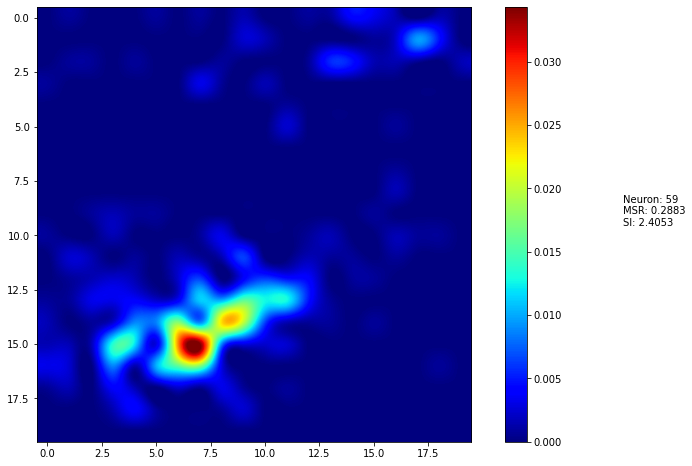

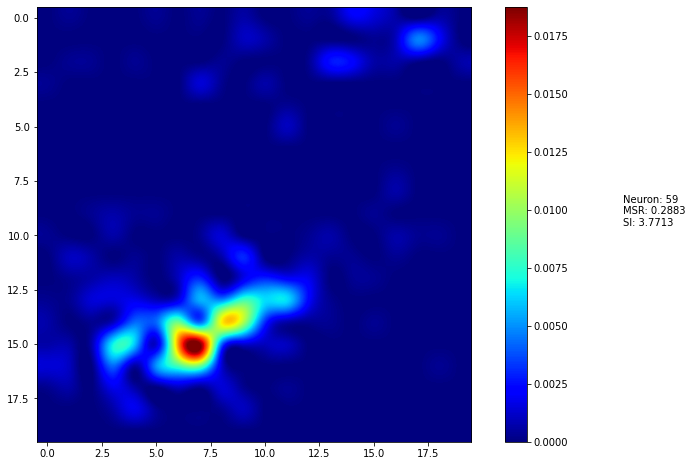

--------------------------------------
Neuron: 7
SI: 2.076003938755638
Smooth SI: 3.0803907062248017
MSR: (0.28609033229931524, 4.1613750267954774e-05)


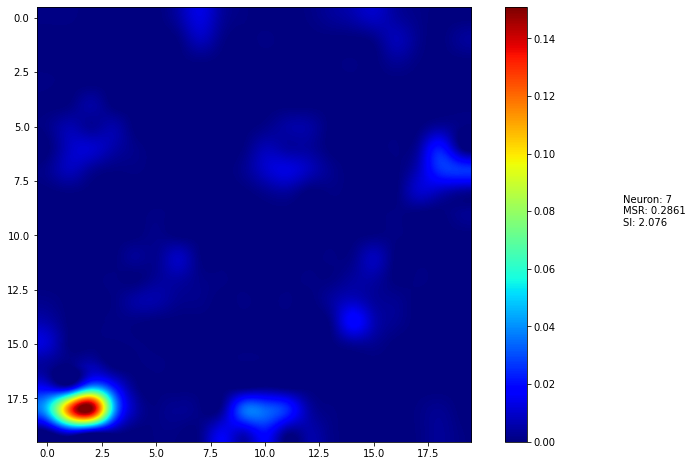

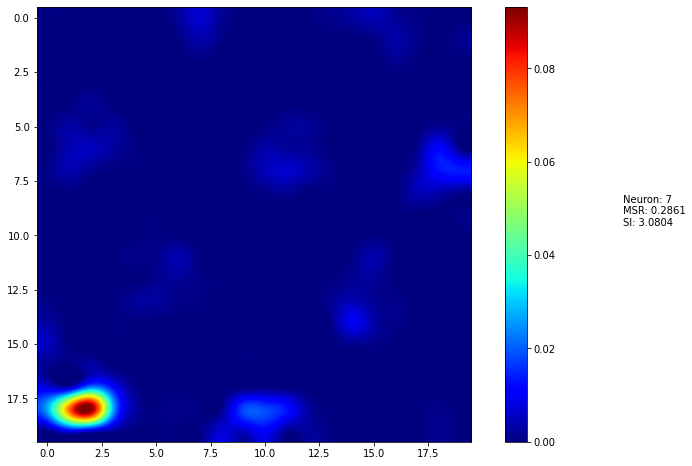

--------------------------------------
Neuron: 29
SI: 2.0238599245508797
Smooth SI: 3.169030207567877
MSR: (0.28536958298846643, 0.0002761107759583492)


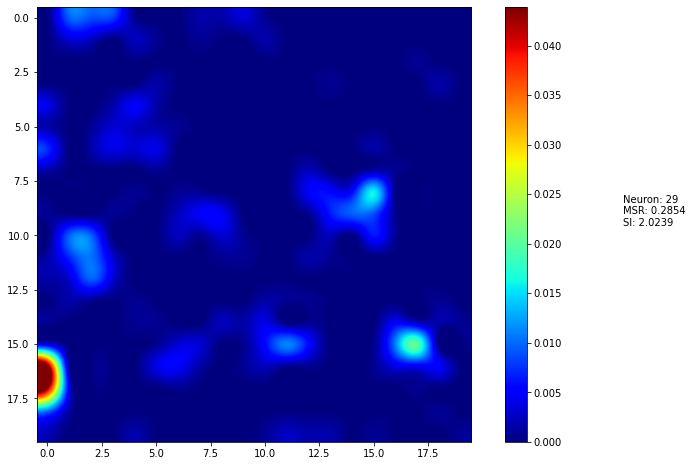

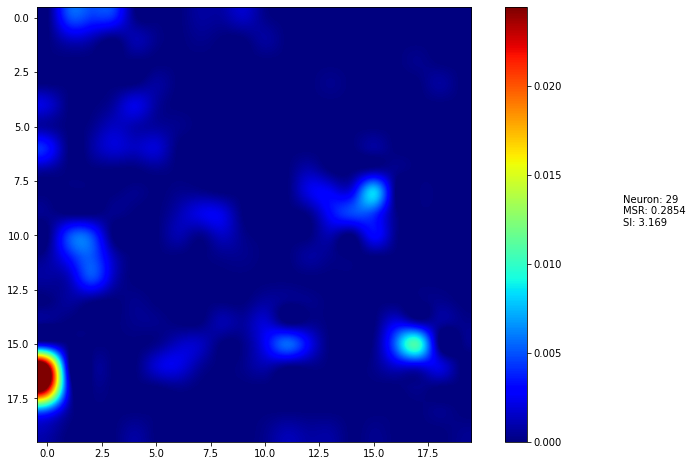

--------------------------------------
Neuron: 13
SI: 1.980750393098241
Smooth SI: 2.9603564162940725
MSR: (0.28204985451300874, 2.471689532396182e-05)


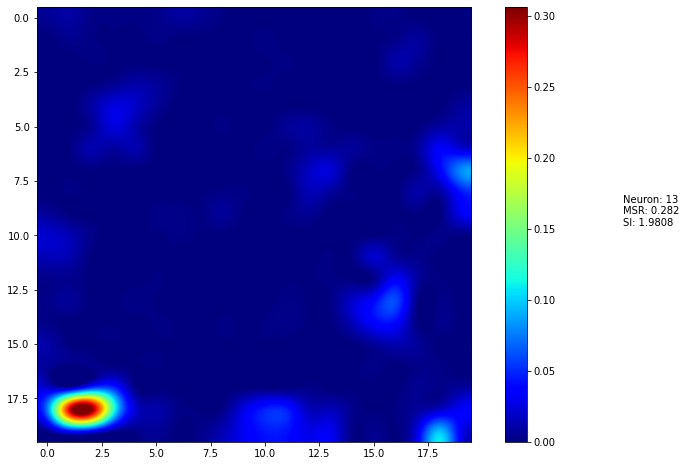

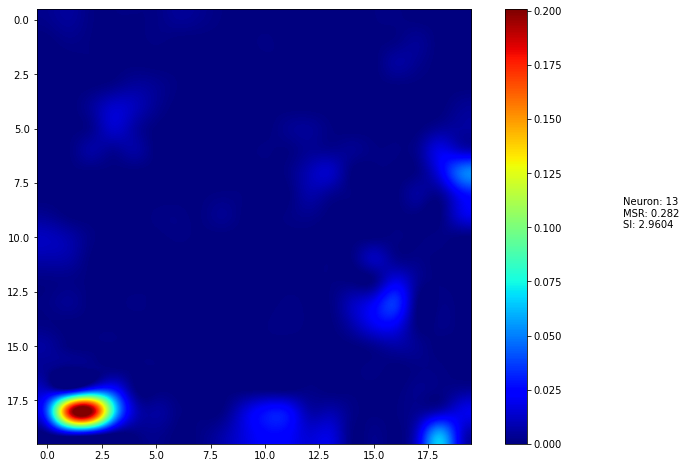

--------------------------------------
Neuron: 63
SI: 1.961104995415171
Smooth SI: 3.011291456877622
MSR: (0.2906454902607293, 0.0005028509999861357)


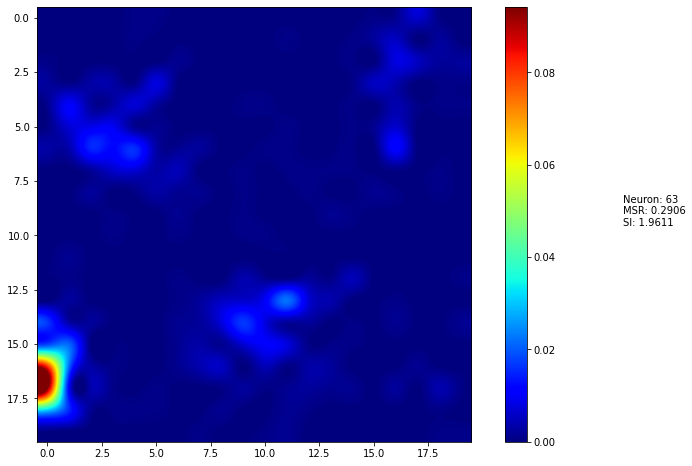

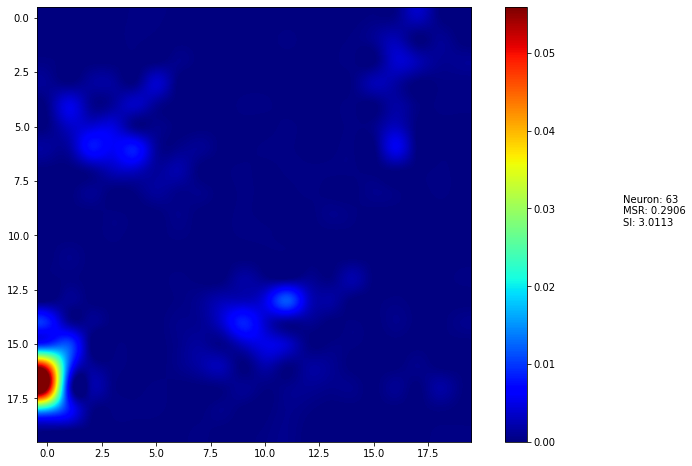

--------------------------------------
Neuron: 15
SI: 1.867855968749009
Smooth SI: 2.842182009968981
MSR: (0.2858433365241838, 1.9872226859507514e-05)


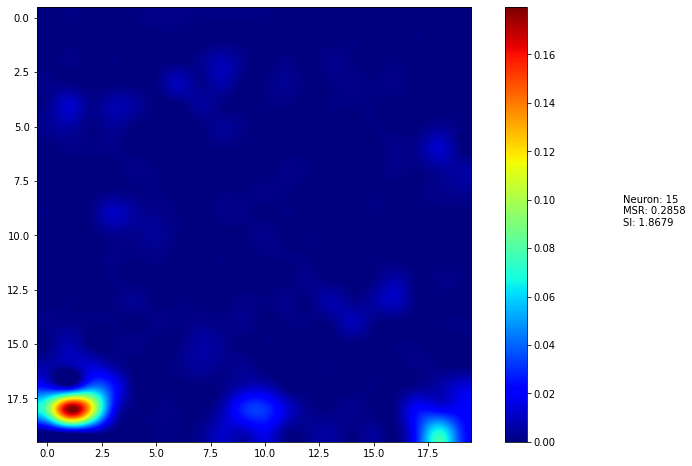

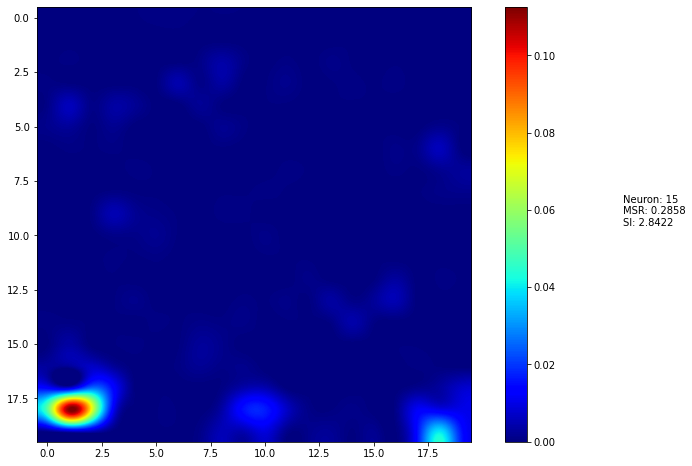

--------------------------------------
Neuron: 56
SI: 1.8247988188671134
Smooth SI: 2.9259875331016025
MSR: (0.28744122834224484, 5.067031647720821e-05)


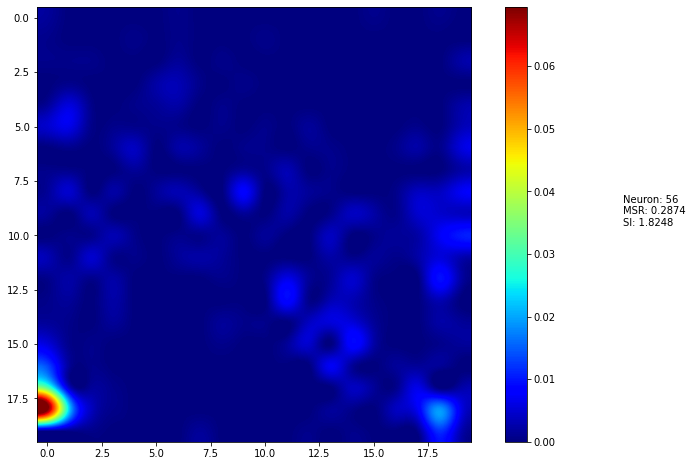

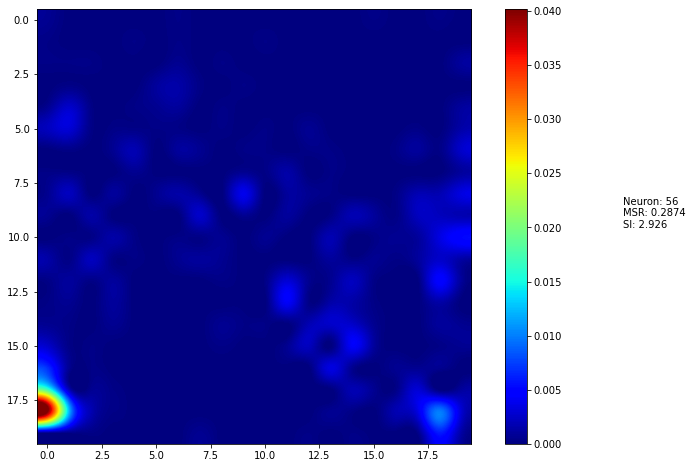

--------------------------------------
Neuron: 60
SI: 1.7969629952530743
Smooth SI: 2.7087968284460513
MSR: (0.2826113320720471, 0.00015639625092273013)


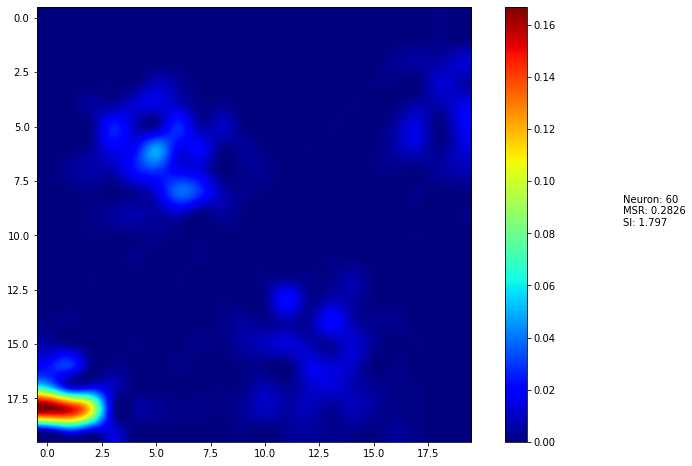

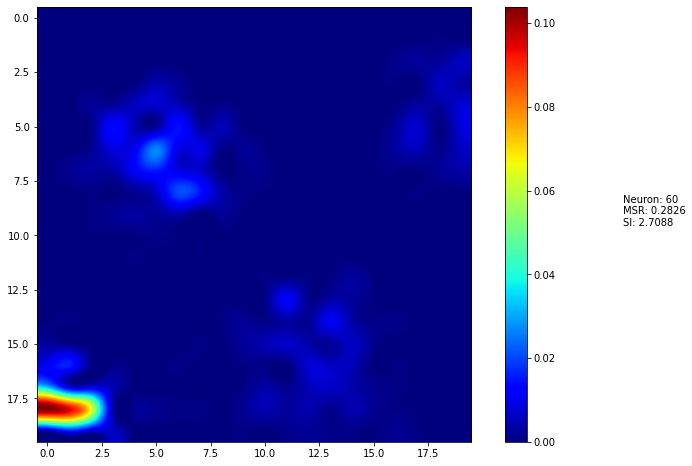

--------------------------------------
Neuron: 26
SI: 1.7904290632258115
Smooth SI: 3.302512034318214
MSR: (0.28861276488242577, 0.00043480625912351674)


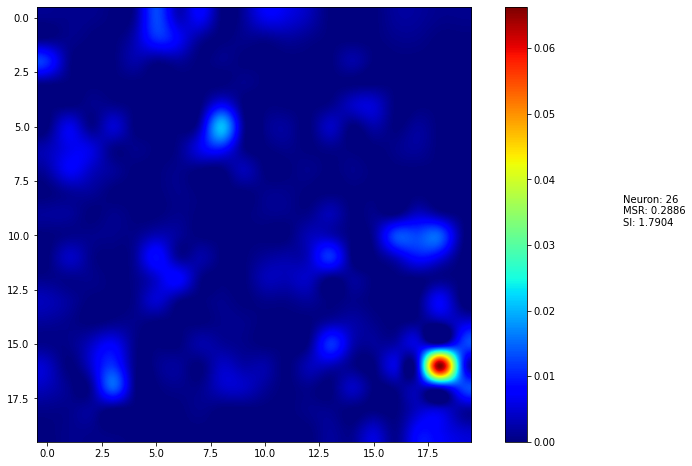

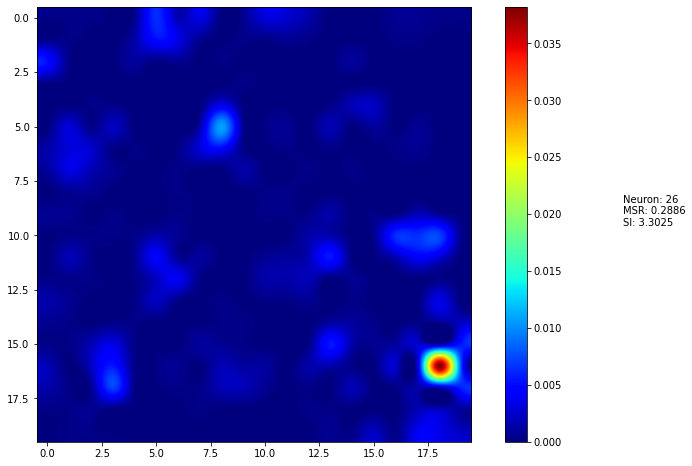

--------------------------------------
Neuron: 28
SI: 1.6969002181644348
Smooth SI: 2.8433342030209006
MSR: (0.2879560030279112, 0.00014699903112319612)


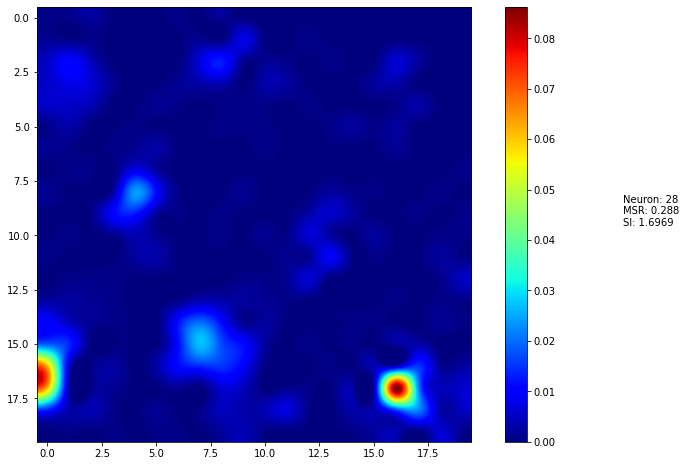

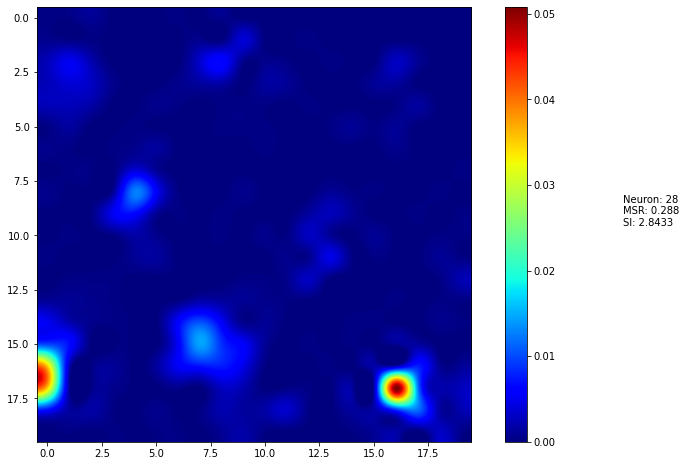

In [ ]:
ranking_sp(SI_NSM, Main_Ne, cell_names)

In [ ]:
MSR_txt.close()
SI_txt.close()
HD_txt.close()

## MSR-SI Scores

In this section I will plot the scores of each neuron on a MSR-SI graph (where I will use the smoothed spatial information measure). 
In particular, I will try to highlight in the graph the position of the top 5 and worst five neuron according to the their MSR score, and assess their respective SI score.

In [ ]:
def scoring(MSRs, SI_SM, Main_Ne, cell_names, M):

  idx = np.zeros(10, dtype=np.int64)
  temp = np.argsort(MSRs)
  idx[:5] = temp[:5]
  idx[5:] = temp[-5:]

  MSRs = np.array(MSRs)
  SI_SM = np.array(SI_SM)

  corr = pearsonr(MSRs, SI_SM)
  txt = 'Pearson r: '+str(round(corr[0],3))

  # Default color for neurons in scatter plot: blue
  # Best MSR scores: green
  # Worst MSR scores: magenta
  l = len(MSRs)
  col = np.array(['b']*l)
  col[idx[:5]] = 'm'
  col[idx[5:]] = 'g'

  # plotting of scores in the MSR-SI plane
  fig, ax = plt.subplots(figsize=(15,10))
  ax.scatter(MSRs, SI_SM, s=80, c=col, marker='X', label='MSR-SI plot')
  ax.set_xlabel('Multiscale Relevance R')
  if M=='SI':
    ax.set_ylabel('Spatial Information SI')
  elif M=='HD':
    ax.set_ylabel('Head Direction Information HD')
  plt.figtext(0.92,0.5, txt)


  for j in range(len(idx)):
    name = cell_names[idx[j]]
    text = 'Neuron '+str(Main_Ne[name]['Neuron'])
    if M=='SI':
      ax.annotate(text, (MSRs[idx[j]], SI_SM[idx[j]]), xytext=(MSRs[idx[j]], SI_SM[idx[j]]))
    elif M=='HD':
      if j<5:
        ax.annotate(text, (MSRs[idx[j]], SI_SM[idx[j]]), xytext=(MSRs[idx[j]], SI_SM[idx[j]]+0.02+0.05*j*np.power(-1,j)), arrowprops=dict(arrowstyle='->',color='k', lw=2.5))
      else:
        ax.annotate(text, (MSRs[idx[j]], SI_SM[idx[j]]), xytext=(MSRs[idx[j]], SI_SM[idx[j]]))

  if M=='SI':
    plt.savefig('Spatial_Information-MSR')
  elif M=='HD':
    plt.savefig('HD_Information-MSR')  


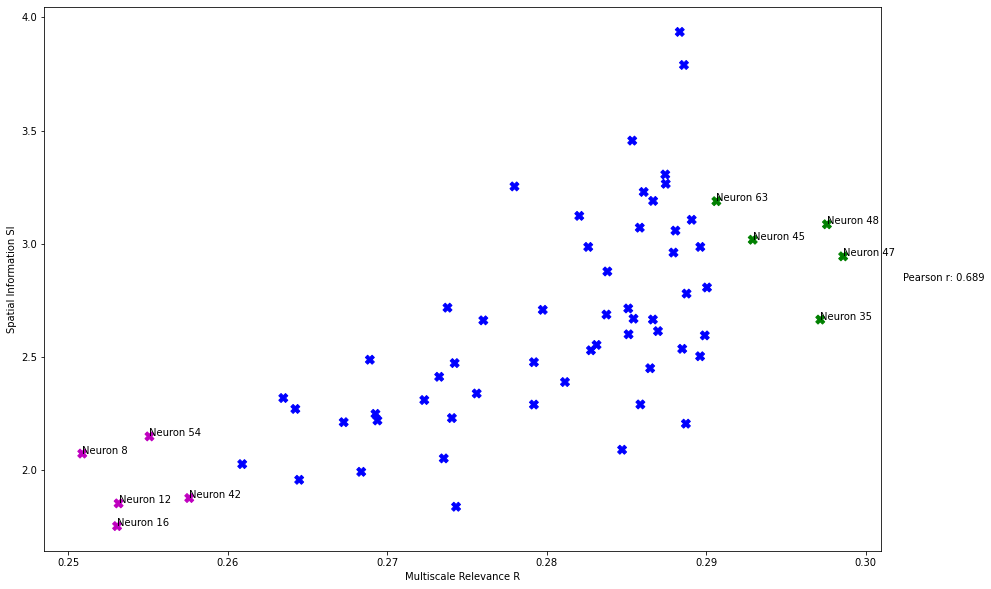

In [ ]:
scoring(MSRs, SI_SM, Main_Ne, cell_names, 'SI')

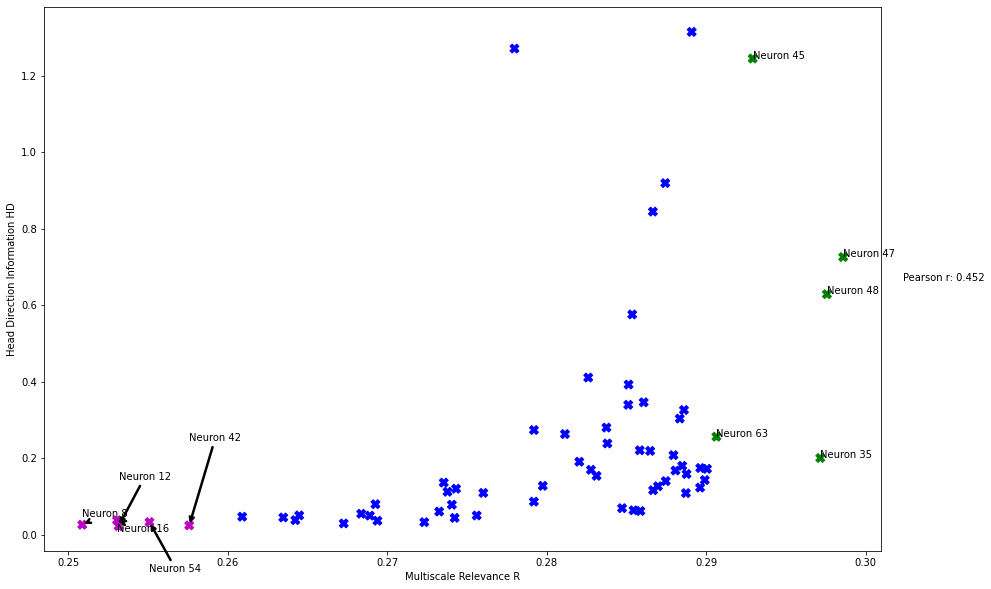

In [ ]:
scoring(MSRs, HD_NSM, Main_Ne, cell_names, 'HD')

## Visualization of the receptive fields
 

In this last block of code I will display the receptive fields of the neurons considered in the paper by Cubero, Marsili, and Roudi.


In [ ]:
def display_rec_fields(n_neu, cell_names, Main_Ne):

  # Taking as input a list of indices for neurons in cell_names and
  # displaying their spatial receptive fields

  # load neuron index
  grid = [7,9,11,13,15,17,19,20,23,24,25,27,28,33,36,37,39,40,41,42,52,60,61,62,63,64,65]
  interneuron = [8,12,16,22,50]

  for neu in n_neu:
    name = cell_names[neu]
    print('####################################')
    print('Neuron: '+str(Main_Ne[name]['Neuron']))
    print('SI: '+str(Main_Ne[name]['SI_smooth']['SI']))
    print('MSR: '+str(Main_Ne[name]['MSR'][0]))
    txt = 'Receptive Field CubNeu: '+str(Main_Ne[name]['Neuron'])
    if Main_Ne[name]['Neuron'] in grid:
      lab = 'Grid Cell: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))+'\n'+'SI: '+str(round(Main_Ne[name]['SI_smooth']['SI'],4))
    elif Main_Ne[name]['Neuron'] in interneuron:
      lab = 'Interneuron: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))+'\n'+'SI: '+str(round(Main_Ne[name]['SI_smooth']['SI'],4))
    elif Main_Ne[name]['Neuron'] in [44]:
      lab = 'Border neuron: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))+'\n'+'SI: '+str(round(Main_Ne[name]['SI_smooth']['SI'],4))
    else:
      lab = 'Neuron: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))+'\n'+'SI: '+str(round(Main_Ne[name]['SI_smooth']['SI'],4))


    plt.figure(figsize=(12,8))
    plt.imshow(Main_Ne[name]['SI_smooth']['lambda(x)'], cmap='jet', interpolation='spline36')
    plt.colorbar()
    plt.figtext(0.9,0.5, lab)
    plt.savefig(txt)
    plt.show()
    plt.close()

####################################
Neuron: 47
SI: 2.5539035178295015
MSR: 0.2985933236266411


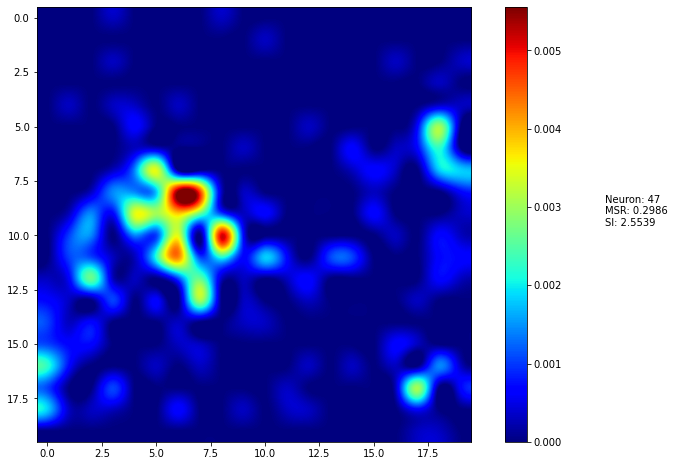

####################################
Neuron: 3
SI: 2.381064438370121
MSR: 0.28991906598308353


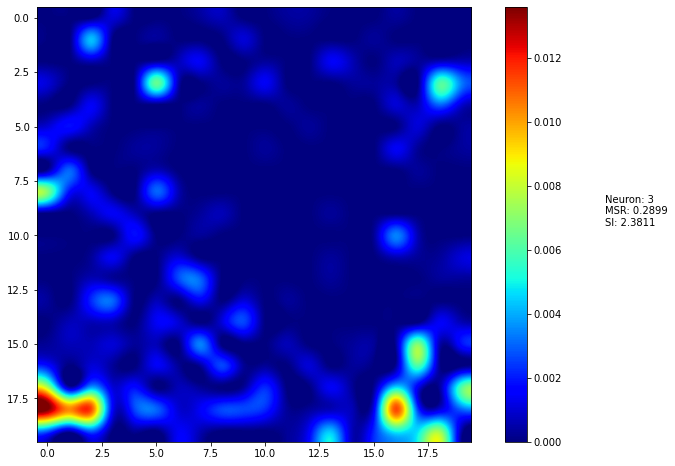

####################################
Neuron: 35
SI: 2.160753592990811
MSR: 0.2971573575205887


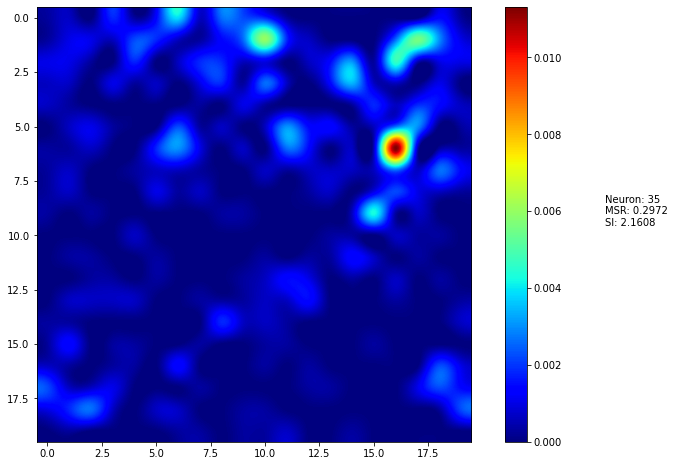

####################################
Neuron: 6
SI: 2.371890083911698
MSR: 0.29005698524867046


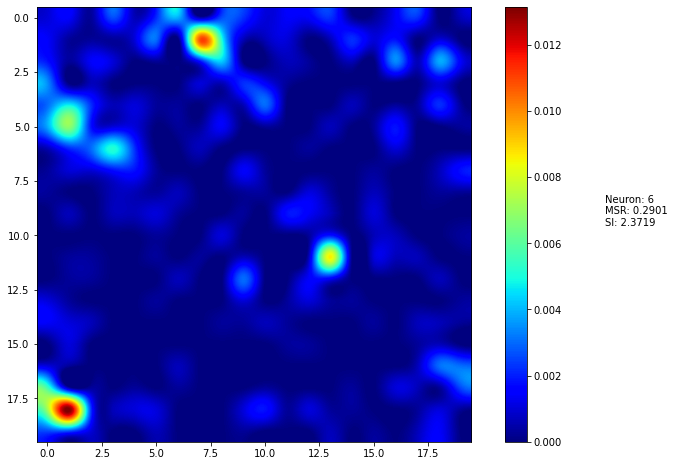

####################################
Neuron: 48
SI: 2.551544693277246
MSR: 0.2975758413293613


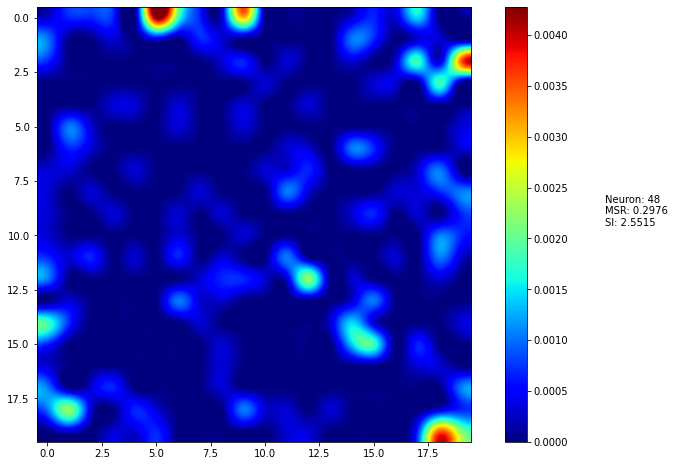

####################################
Neuron: 8
SI: 1.764376030511511
MSR: 0.2508894286062685


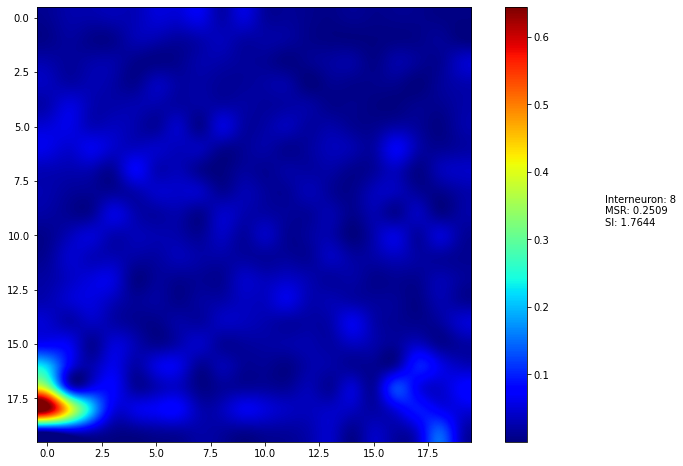

####################################
Neuron: 54
SI: 1.846560581747281
MSR: 0.25510382451336827


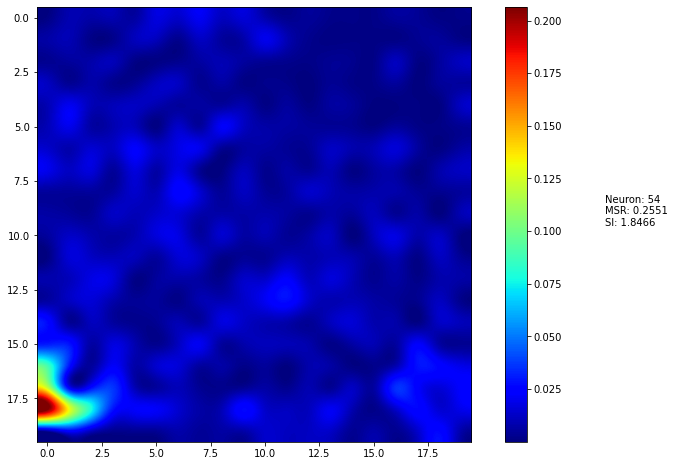

####################################
Neuron: 16
SI: 1.4856060107397666
MSR: 0.2530736604401562


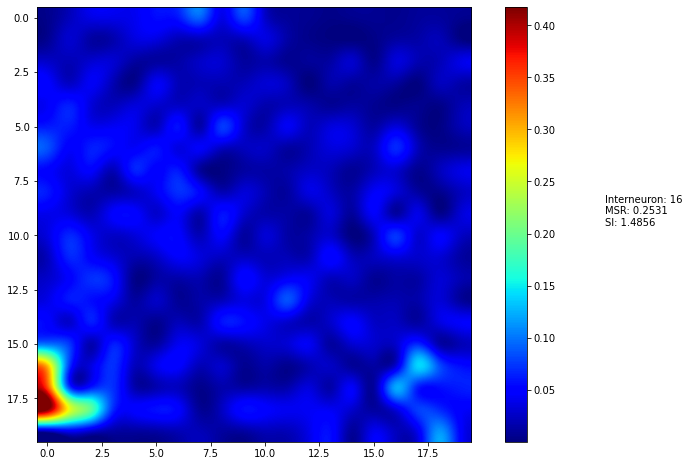

####################################
Neuron: 12
SI: 1.5936031518411191
MSR: 0.25316909433890583


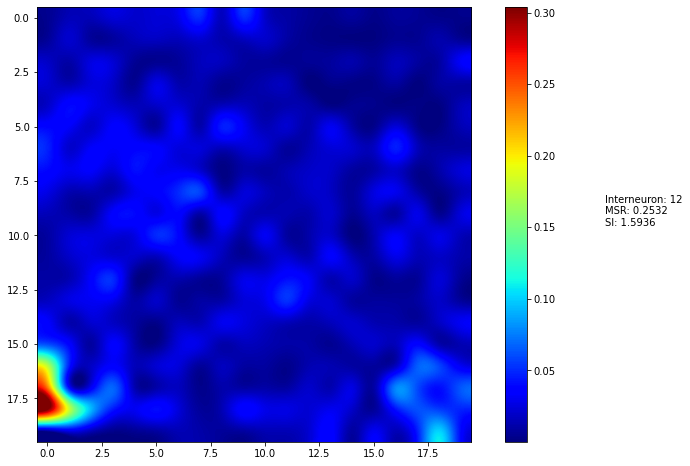

####################################
Neuron: 42
SI: 1.6308061666339857
MSR: 0.2575972624727846


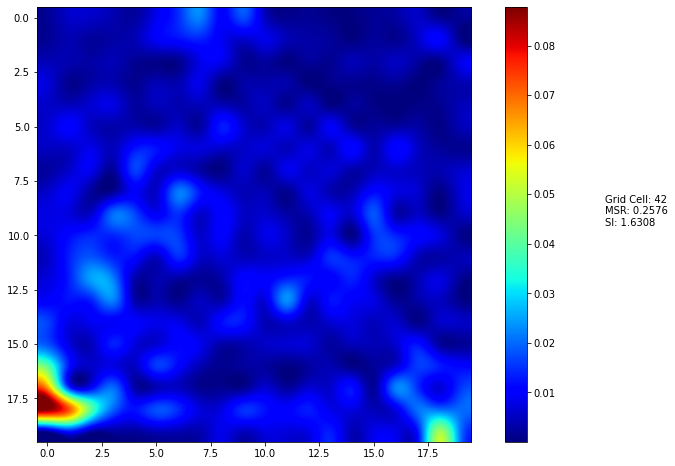

In [ ]:
n_neu = [46, 2, 34, 5, 47, 7, 53, 15, 11, 41]
display_rec_fields(n_neu, cell_names, Main_Ne)

In [ ]:
def display_HD_rc_fields(n_neu, cell_names, Main_Ne):
  # Taking as input a list of indices for neurons in cell_names and
  # displaying their polar receptive fields

  # load neuron index
  grid = [7,9,11,13,15,17,19,20,23,24,25,27,28,33,36,37,39,40,41,42,52,60,61,62,63,64,65]
  interneuron = [8,12,16,22,50]

  for neu in n_neu:
    name = cell_names[neu]
    print('####################################')
    txt = 'Receptive Field HD CubNeu: '+str(Main_Ne[name]['Neuron'])
    if Main_Ne[name]['Neuron'] in grid:
      lab = 'Grid Cell: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))+'\n'+'HD: '+str(round(Main_Ne[name]['HD']['HD'],4))
    elif Main_Ne[name]['Neuron'] in interneuron:
      lab = 'Interneuron: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))+'\n'+'SI: '+str(round(Main_Ne[name]['HD']['HD'],4))
    elif Main_Ne[name]['Neuron'] in [44]:
      lab = 'Border neuron: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))+'\n'+'SI: '+str(round(Main_Ne[name]['HD']['HD'],4))
    else:
      lab = 'Neuron: '+str(Main_Ne[name]['Neuron'])+'\n'+'MSR: '+str(round(Main_Ne[name]['MSR'][0],4))+'\n'+'SI: '+str(round(Main_Ne[name]['HD']['HD'],4))


    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(np.linspace(0, 2*np.pi, 40), Main_Ne[name]['HD']['lambda(x)'], 'o', linestyle='-')
    plt.figtext(0.8,0.6, lab)
    plt.savefig(txt)
    plt.show()
    plt.close()

####################################


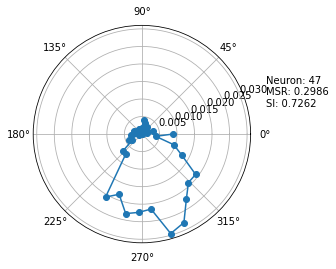

####################################


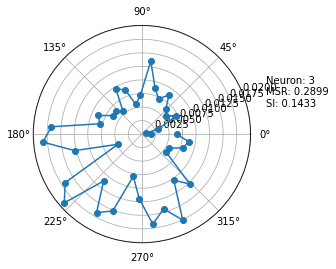

####################################


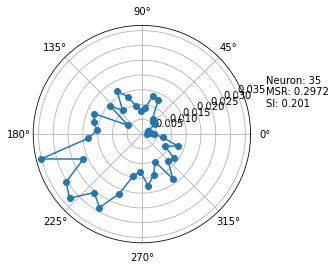

####################################


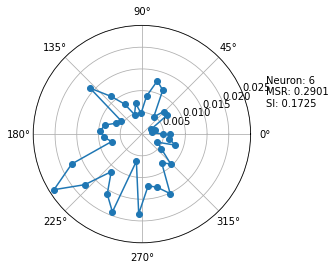

####################################


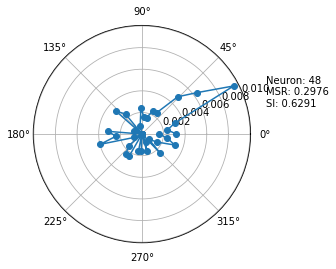

####################################


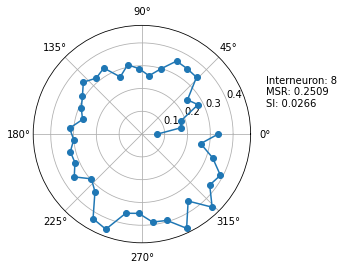

####################################


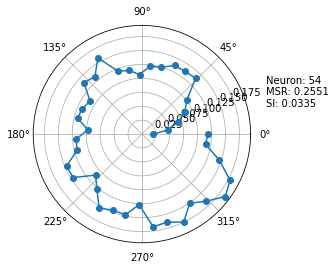

####################################


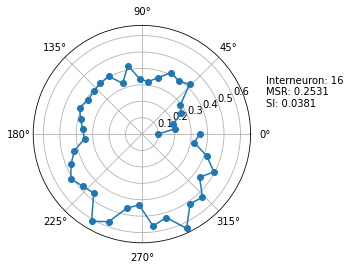

####################################


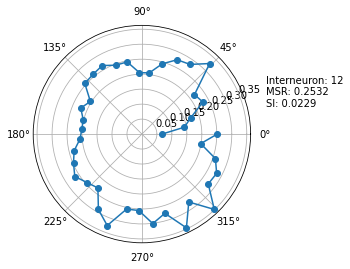

####################################


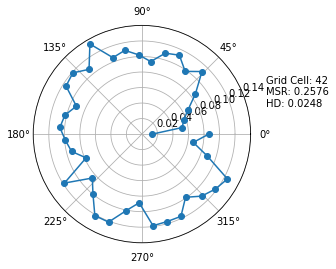

In [ ]:
n_neu = [46, 2, 34, 5, 47, 7, 53, 15, 11, 41]
display_HD_rc_fields(n_neu, cell_names, Main_Ne)